In [2]:
# !pip install graphviz

In [3]:
def f(x):
    return 3*x**2 + 2*x + 10

In [4]:
# calculate derivative
def derivative_f(x):
    h = 0.00000001
    return (f(x+h) - f(x))/h
    

In [5]:
# calculate derivative at x=-1/4

derivative_f(-1/4)

0.5000000413701855

In [6]:
# derivative is zero at x=-1/3

derivative_f(x=-1/3)

1.7763568394002505e-07

In [7]:
# implement value object that supports mathematical operations like sum and multiply and back tracks on grad and calculation

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return "Value(data={})".format(self.data)
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
        

In [8]:
a = Value(6.0, label='a')
b = Value(10.0, label='b')
c = Value(4.0, label='c')
e = a*b; e.label = 'e'
d = e + c ;d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

In [9]:
# Display graphical representation of value

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s |data %.4f | grad %.4f  }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

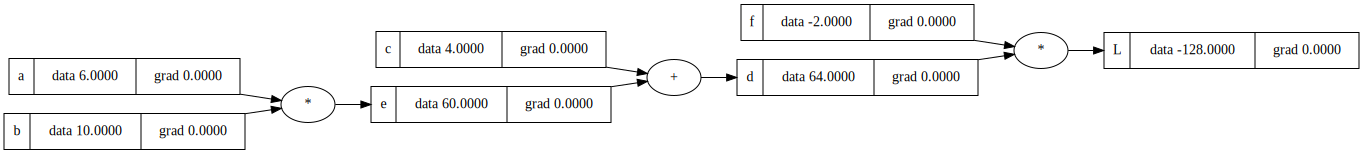

In [10]:
draw_dot(L)

In [11]:
# fill in grad manually for backward pass

L.grad = 1.0
d.grad = -2.0
f.grad = 64.0
e.grad = -2.0
c.grad = -2.0
a.grad = -2.0 * 10.0
b.grad = -2.0 * 6.0

In [12]:
#calculate grad locally

def lol():
    h = 0.0001
    a = Value(6.0, label='a')
    b = Value(10.0, label='b')
    c = Value(4.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c ;d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(6.0, label='a')
    b = Value(10.0, label='b')
    b.data+=h
    c = Value(4.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c ;d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    
    return (L2-L1)/h

    
lol()    

-11.999999999829924

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import math

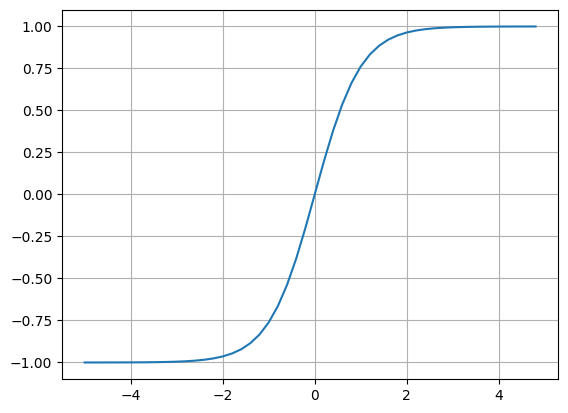

In [14]:
# Tanh can be used as squashing function
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [15]:
# Add new operations for accommodate tanh calculation 

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda : None
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return "Value(data={})".format(self.data)
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t , (self, ), "tanh")

        def _backward():
            self.grad = (1-t**2) * out.grad
            
        out._backward = _backward
        return out

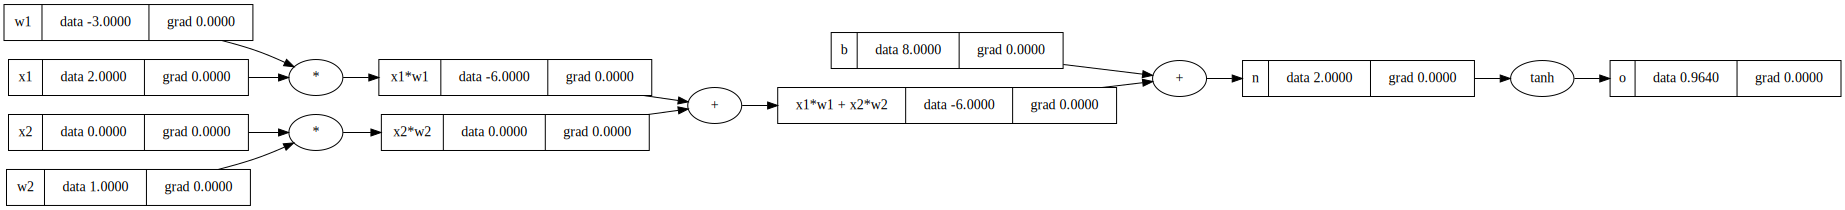

In [54]:
# Another example of backpropagation using nearon of type wx+b

#input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(8, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Final Neuron
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = "o"

draw_dot(o)

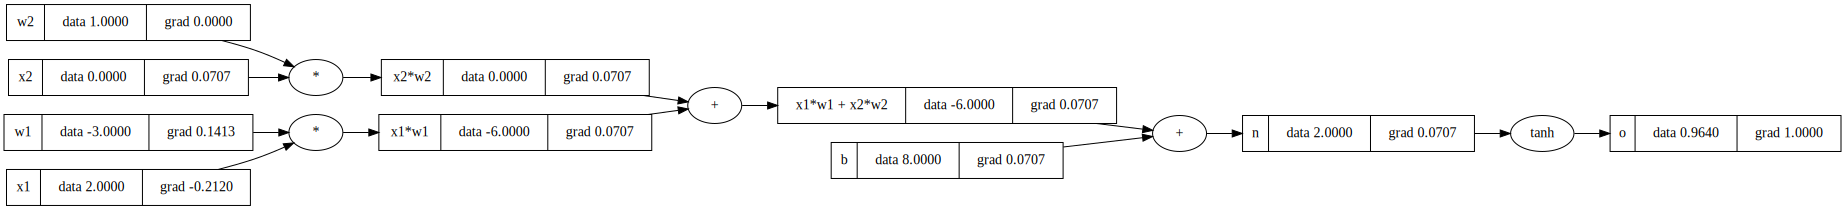

In [31]:
# fill in gradients for back propagation manually
o.grad = 1.0

#do/dn = 1- o**2
n.grad = (1-(o.data**2))

#do/db = do/dn * dn/db; n = z + b; dn/db=1
b.grad = n.grad
x1w1x2w2.grad = n.grad

# do/dx1w1  = do/dn * dx1w1x2w1/dx2w2 * dn/dx1w1x2w2
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)

In [18]:
# fill in grad i.e. back propogate automatically by calling backward function
o.grad = 1.0
o._backward()

In [19]:
n._backward()

In [20]:
b._backward()

In [21]:
x1w1x2w2._backward()

In [22]:
x1w1._backward()

In [23]:
x2w2._backward()

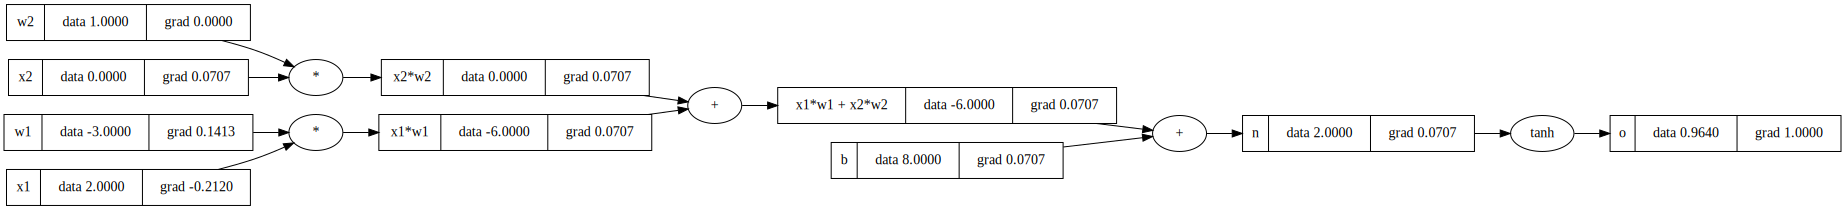

In [24]:
draw_dot(o)

### Use topological sort to call backward in reversed order on each node

In [38]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for node in reversed(topo):
    node._backward()

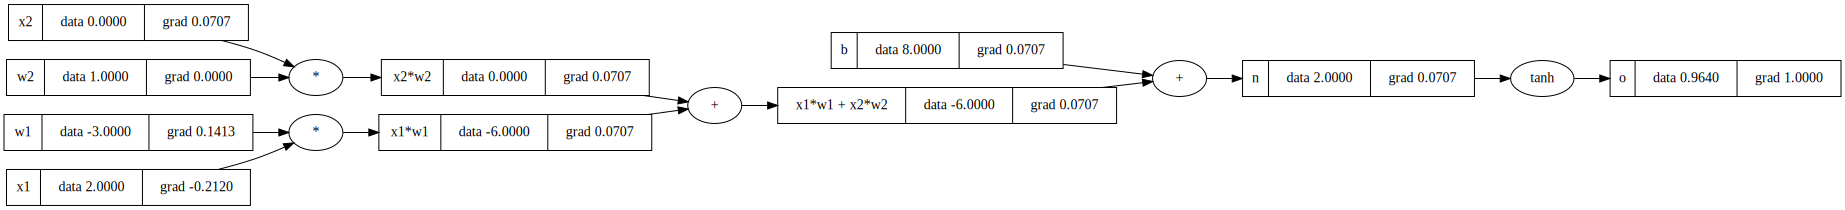

In [36]:
draw_dot(o)

#### Add backward function in Value Class

In [53]:
# Add new operations for accommodate tanh calculation 

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda : None
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return "Value(data={})".format(self.data)
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t , (self, ), "tanh")

        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

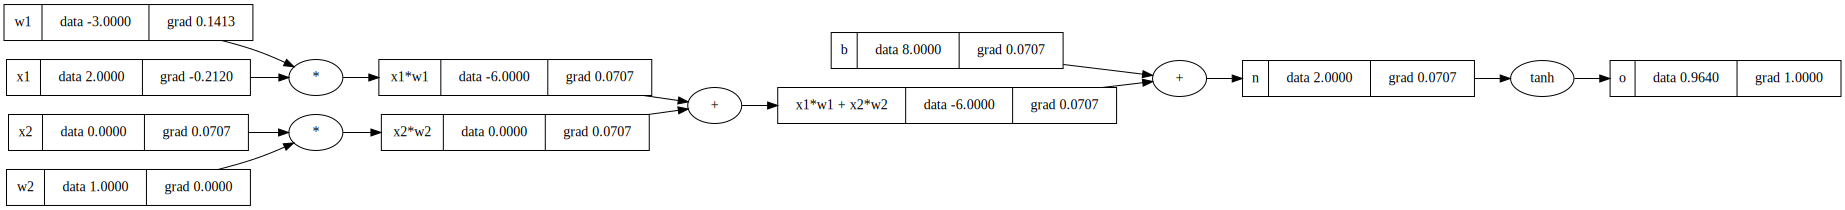

In [55]:
o.backward()
draw_dot(o)

### Fixing the accumulation bug. Gradients should not reset but update

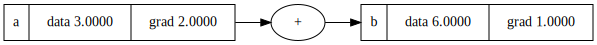

In [52]:
a = Value(3.0, label="a")
b = a+a; b.label = "b"
b.backward()
draw_dot(b)

### Break down tanh in simple function

In [79]:
# Add new operations for accommodate tanh calculation 

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda : None
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return "Value(data={})".format(self.data)
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supports int and float"
        out = Value(self.data**other, (self, ), f'**(other)')

        def _backward():
            self.grad = other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t , (self, ), "tanh")

        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def exp(self):
        n = self.data
        out = Value(math.exp(n), (self, ), "exp")

        def _backward():
            self.grad =out.data * out.grad
        out._backward = _backward
        return out

    

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [80]:
a = Value(1.0)
b = Value(2.0)
a-b


Value(data=-1.0)

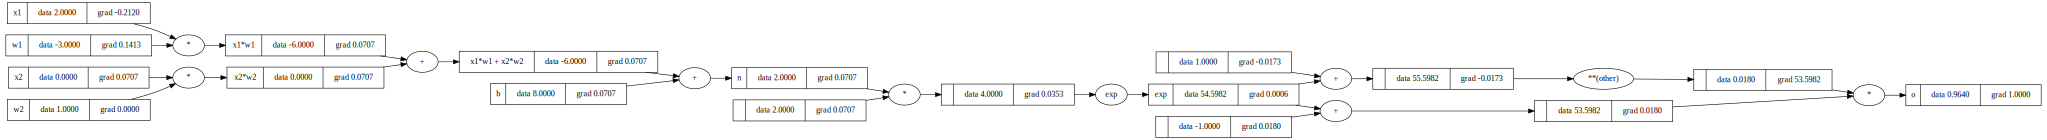

In [83]:
# Another example of backpropagation using nearon of type wx+b

#input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(8, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Final Neuron
n = x1w1x2w2 + b; n.label = 'n'


# Smooth Function ( redefine tanh)
e = (2*n).exp(); e.label = "exp"
o = (e-1)/(e+1); o.label = "o"
# o = n.tanh(); o.label = "o"
o.backward()
draw_dot(o)

### Reimplement same in PyTorch

In [85]:
import torch

ModuleNotFoundError: No module named 'torch'

In [86]:
!pip install pytorch

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-m8vr4tlr/pytorch_6f1110ff9cfd4310962c9e08442168ea/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [87]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 322.6 kB/s eta 0:00:00 eta 0:00:010:00:04m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 591.8 kB/s eta 0:00:00 eta 0:00:010:00:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 6.7 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 5.7 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 4.2 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 448.6 kB/s eta 0:00:00 eta 0:00:010:00:03m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.8 MB/s eta 0:00:00m eta 0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:01m
 